In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

# Data preprocessing

In [2]:
df_import_2015 = pd.read_excel('DATA/Import/Import-2015.xlsx')

In [ ]:
df_import_2016 = pd.read_excel('DATA/Import/Import-2016.xlsx')

In [ ]:
df_import_2017 = pd.read_excel('DATA/Import/Import-2017.xlsx')

In [2]:
df_import_2018 = pd.read_excel('DATA/Import/Import-2018.xlsx')

In [3]:
df_import_2019 = pd.read_excel('DATA/Import/Import-2019.xlsx')

In [4]:
df_import_2020 = pd.read_excel('DATA/Import/Import-Janar-Dhjetor-2020.xlsx')

In [5]:
df_import_2021 = pd.read_excel('DATA/Import/Import-Janar-Shkurt-2021.xlsx')

In [6]:
import_df = pd.concat([df_import_2015,df_import_2016,df_import_2017,
                       df_import_2018,df_import_2019,df_import_2020,df_import_2021],
                      axis=0).reset_index(drop=True)

In [7]:
import_df.drop(['Regjimi','Origjina','Kodi Tarifor','Sasia','Vlera Mallrave','Netweight'],axis=1,inplace=True)

In [8]:
import_df['revenue'] = import_df['Taksa Doganës'] + import_df['Taksa Akcizës'] + import_df['Taksa TVSH-së']

In [9]:
import_df.drop(['Taksa Doganës','Taksa Akcizës','Taksa TVSH-së'],axis=1,inplace=True)

In [10]:
import_df

,VITI,MUAJI,revenue
0,2018,1,55504.44
1,2018,1,202268.57
2,2018,1,2541676.99
3,2018,1,173818.43
4,2018,1,8697.30
...,...,...,...
637739,2021,2,48.33
637740,2021,2,399.23
637741,2021,2,0.00
637742,2021,2,1113.93


In [184]:
# import_df[(import_df['MUAJI'] == 1)][import_df['VITI'] == 2018].sum()

In [11]:
mi_df = import_df.groupby([(import_df['VITI']),(import_df.MUAJI)]).sum()

In [12]:
mi_df.head()

revenue
VITI MUAJI             
2018 1      62953745.31
     2      66958785.41
     3      80449479.50
     4      88911890.04
     5      98208820.93

In [13]:
df = mi_df.reset_index(level=[0,1])

In [14]:
df.head()

,VITI,MUAJI,revenue
0,2018,1,62953745.31
1,2018,2,66958785.41
2,2018,3,80449479.50
3,2018,4,88911890.04
4,2018,5,98208820.93


In [15]:
new_col = df[['VITI','MUAJI']].apply(lambda x : '{}-{}'.format(x[0],x[1]), axis=1)
df.insert(loc=0, column='date', value=new_col)
df.drop(['VITI','MUAJI'],axis=1,inplace=True)

In [16]:
df.head()

,date,revenue
0,2018-1,62953745.31
1,2018-2,66958785.41
2,2018-3,80449479.50
3,2018-4,88911890.04
4,2018-5,98208820.93


In [17]:
df_income = df.copy()

In [18]:
df_income['date'] = pd.to_datetime(df_income.date)

In [19]:
df_income.head()

,date,revenue
0,2018-01-01,62953745.31
1,2018-02-01,66958785.41
2,2018-03-01,80449479.50
3,2018-04-01,88911890.04
4,2018-05-01,98208820.93


In [23]:
df_income.date[1]

Timestamp('2018-02-01 00:00:00')

In [20]:
df_income.set_index("date",inplace=True)

In [21]:
df_income.head()

,revenue
date,
2018-01-01,62953745.31
2018-02-01,66958785.41
2018-03-01,80449479.50
2018-04-01,88911890.04
2018-05-01,98208820.93


# Data normalization

In [188]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_income['scaled'] = scaler.fit_transform(df_income)

## SARIMA MODEL

In [83]:
catfish_sales = df_income.asfreq(pd.infer_freq(df_income.index))

In [84]:
start_date = datetime(2018,1,1)
end_date = datetime(2021,2,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

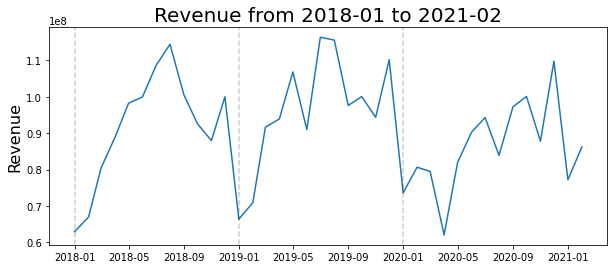

In [85]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Revenue from 2018-01 to 2021-02', fontsize=20)
plt.ylabel('Revenue', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [86]:
# REMOVE THE TREND
first_diff = lim_catfish_sales.diff()[1:]

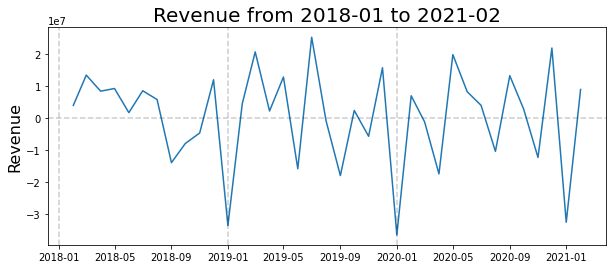

In [87]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Revenue from 2018-01 to 2021-02', fontsize=20)
plt.ylabel('Revenue', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## Rolling FORECAST

In [95]:
# Get training and testing sets
train_end = datetime(2020,1,1)
test_end = datetime(2021,2,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

In [96]:
test_data.size

13

In [97]:
train_data.size

25

In [98]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)

In [99]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [100]:
rolling_residuals = test_data - rolling_predictions

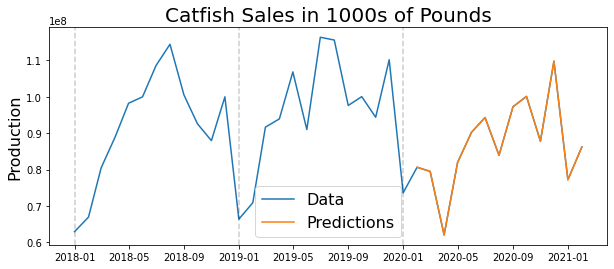

In [101]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Detecting the anomaly

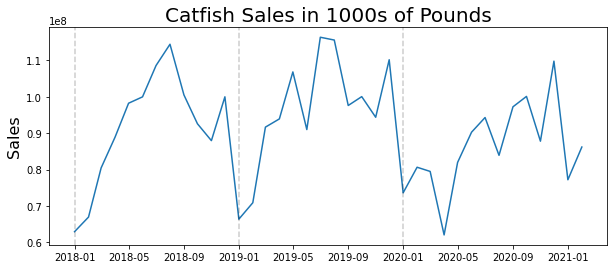

In [103]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [161]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance

In [163]:
df_income.head()

,scaled
date,
2018-01-01,0.016423
2018-02-01,0.090239
2018-03-01,0.338880
2018-04-01,0.494848
2018-05-01,0.666195


In [165]:
delta = df_income.copy()
meanValue = delta.mean()
covValue = delta.cov()

In [166]:
from numpy.linalg import inv

X = delta.to_numpy()
S = covValue.to_numpy()
for i in range(1):
    X[:,i] = X[:,i] - meanValue[i]
    
def mahalanobis(row):
    return np.matmul(row,S).dot(row)   
    
anomaly_score = np.apply_along_axis( mahalanobis, axis=1, arr=X)

In [167]:
knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(delta.to_numpy())
distances, indices = nbrs.kneighbors(delta.to_numpy())

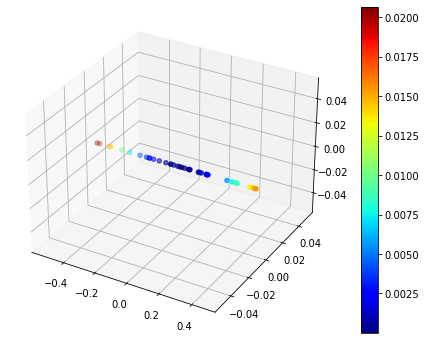

In [175]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.scaled,ys=0,c=anomaly_score,cmap='jet')
fig.colorbar(p)

In [176]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta,anom), axis=1)
result.nlargest(5,'Anomaly score')

,scaled,Anomaly score
date,,
2020-04-01,-0.534507,0.020680
2018-01-01,-0.518084,0.019428
2019-07-01,0.465493,0.015684
2019-01-01,-0.454783,0.014971
2019-08-01,0.451294,0.014742


<AxesSubplot:xlabel='date'>

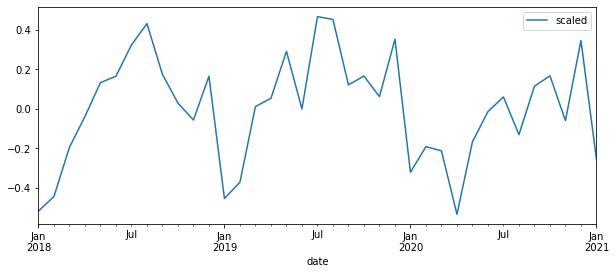

In [181]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ts = delta[0:37]
ts.plot.line(ax=ax)